In [1]:
import warnings
warnings.filterwarnings("ignore")
#evitamos los warnings

#Import libraries
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import string 
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import json
import re
import requests
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#import dataset
dataset = pd.read_excel("https://github.com/AnthonyWainer/acosoEnTwitter/blob/main/dataSet/dataset_twitter.xlsx?raw=true")

display(dataset.sort_index().head(5))
print('\n Hay {} observaciones con {} características'.format(*dataset.shape))

,Tweet,Y
0,RT @CesarAcunaP: Es necesario monitorear los a...,noAcoso
1,"RT @CesarAcunaP: En la reunión, los dirigentes...",noAcoso
2,RT @CarmenOmonte: Reunidos para trabajar por e...,noAcoso
3,RT @CesarAcunaP: En Trujillo estamos junto a l...,noAcoso
4,@CesarAcunaP y ya decia yo de donde tanta plat...,noAcoso



 Hay 474 observaciones con 2 características


### Análisis exploratorio de los datos

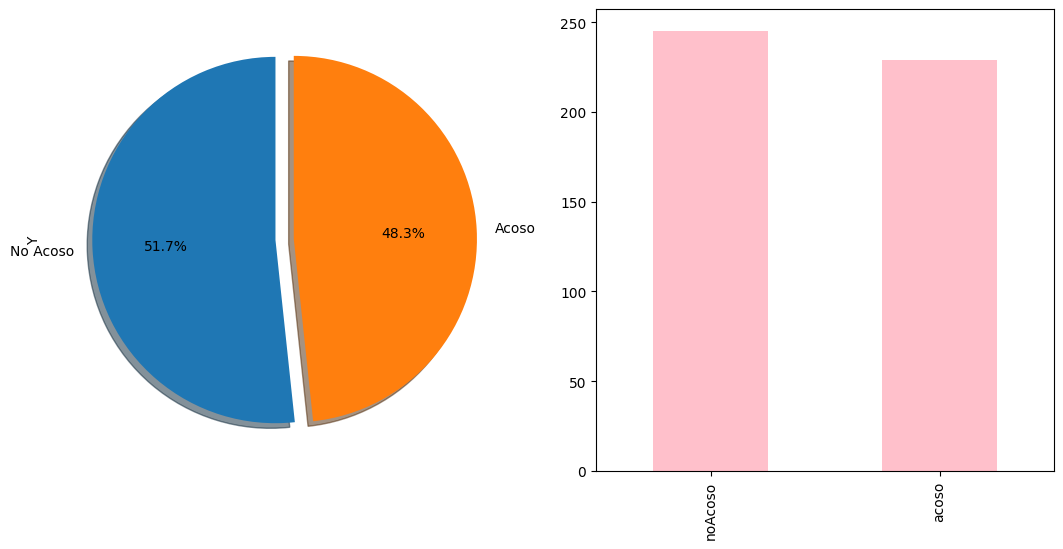

In [3]:
plt.style.use('default')

fig, axs = plt.subplots(1,2, figsize=(13,6))

labels = "No Acoso", "Acoso"
dataset.Y.value_counts().plot.pie(explode = [0,0.1], labels = labels, 
                             ax=axs[0], autopct='%1.1f%%', shadow = True, startangle = 90, title="")

dataset.Y.value_counts().plot.bar(ax=axs[1], 
                                        color = 'pink', title="")

plt.show()

### Procesamiento

In [4]:
#Dividimos el dataset en un conjunto de entranmiento y un conjunto de prueba (30%)
dataset_train, dataset_test= train_test_split(dataset, test_size=0.3, random_state=0)

In [5]:
add_stop_words = ["rt", "si", "va", "ve", "don"]


def get_words(text_content):
    """ Function to get words from text content

        @param text_content    The text content
    """  
    text_in_lower = str(text_content).lower()

    emojiToText = emoji.replace_emoji(text_in_lower)

    only_text = re.sub(r'(@[A-Za-z0-9]+)|(http\S+)|([^a-záéíóúñ ]+)', ' ', emojiToText)

    return only_text.split()


def processing_words(text_content):
    """ Function to processing words from text content

        @param text_content    The text content
    """

    words = get_words(text_content)

    spanish_stops = set(stopwords.words('spanish') + add_stop_words )

    return " ".join([word for word in words if word not in spanish_stops])

def preprocess_dataset(dataset):
  preprocessed_dataset = dataset.copy().dropna()
  
  preprocessed_dataset.drop_duplicates(['Tweet'], keep='first', inplace=True)

  label_encoder = LabelEncoder()

  preprocessed_dataset["Y"] = label_encoder.fit_transform(preprocessed_dataset["Y"].astype(str))
  labels = dict(enumerate(label_encoder.classes_))

  print("Para la columna '{}', la codificación fue: {}".format("Y", labels))

  return preprocessed_dataset, labels

class EmojiDecode():

  def __init__(self, emoji_path):
    emoji_file = requests.get(emoji_path)
    self.emojis = json.loads(emoji_file.text)

  def multiple_replace(self, di, text):
    regex = re.compile("(%s)" % "|".join(map(re.escape, di.keys())))

    return regex.sub(lambda mo: di[mo.string[mo.start():mo.end()]], text) 

  def filter_emojis(self, by_replace):
    return {i : self.emojis[i] for i in by_replace if i in self.emojis.keys()}    

  def replace_emoji(self, text):
    by_replace = list(set(re.findall(r'[^\w\s,]', text)))
    if not by_replace:
      return text

    emojis = self.filter_emojis(by_replace)
    if not emojis:
      return text

    return self.multiple_replace(emojis, text)    

emoji = EmojiDecode('https://github.com/AnthonyWainer/acosoEnTwitter/blob/main/dataSet/emoticones.json?raw=true')  

In [6]:
#limpieza para train

dataset_train.loc[:, ('Tweet_Limpio')] = dataset_train.Tweet.apply(processing_words)

In [7]:
dataset_train.sort_index(inplace=True)

dataset_train.head(10)

,Tweet,Y,Tweet_Limpio
0,RT @CesarAcunaP: Es necesario monitorear los a...,noAcoso,necesario monitorear avances gobierno respecto...
2,RT @CarmenOmonte: Reunidos para trabajar por e...,noAcoso,reunidos trabajar país peruanos dirigentes app t
3,RT @CesarAcunaP: En Trujillo estamos junto a l...,noAcoso,trujillo junto dirigencia fijar lineamientos d...
9,En Trujillo estamos junto a la dirigencia y la...,noAcoso,trujillo junto dirigencia fijar lineamientos d...
11,RT @JovenesMorados_: Frente al desempleo por l...,noAcoso,frente desempleo pandemia jóvenes mujeres enca...
13,@julioguzmanperu ahi te hablan https://t.co/FQ...,noAcoso,ahi hablan
16,@julioguzmanperu @partidomorado Hijos de la gr...,acoso,hijos gran p vende patria jodan rechazado cara...
17,RT @Pulmon_de_Susan: @julioguzmanperu @partido...,noAcoso,susan oe pata pilar técnico acuerdo escazú
18,RT @partidomorado: El Partido Morado cuenta co...,noAcoso,partido morado cuenta técnicos decenas discipl...
19,"RT @JovenesMorados_: Mañana, a las 7pm, tenemo...",noAcoso,mañana pm viernesrepublicanos impacto cambio c...


In [8]:
#limpieza para test

dataset_test.loc[:, ('Tweet_Limpio')] = dataset_test.Tweet.apply(processing_words)

In [9]:
dataset_test.sort_index(inplace=True)

dataset_test.head(10)

,Tweet,Y,Tweet_Limpio
1,"RT @CesarAcunaP: En la reunión, los dirigentes...",noAcoso,reunión dirigentes congresistas analizando pro...
4,@CesarAcunaP y ya decia yo de donde tanta plat...,noAcoso,decia tanta plata coca sanchez paredes x q inv...
5,@CesarAcunaP @BancadaAPP @Peru_APP Qué ha echo...,noAcoso,app echo partido detener covid echo detener g
6,@CesarAcunaP @BancadaAPP @Peru_APP Y que fue s...,noAcoso,app devolución afp millones aportantes ex apor...
7,@CesarAcunaP @BancadaAPP @Peru_APP Estimado Ce...,noAcoso,app estimado cesar podría triunfar partido hac...
8,"En la reunión, los dirigentes y congresistas e...",noAcoso,reunión dirigentes congresistas analizando pro...
10,Extiendo mi solidaridad con el fundador de @po...,noAcoso,extiendo solidaridad fundador peru josé luna g...
12,RT @ZENAIDASOLISG: Por fin el Perú tendrá una ...,noAcoso,fin perú ley antimonopolio día histórico parti...
14,@julioguzmanperu @partidomorado https://t.co/s...,noAcoso,
15,@julioguzmanperu @partidomorado Me cago en est...,acoso,cago jóvenes ignorantes carajo nunca hablaron ...


Text(0.5, 1.0, 'Palabras más frecuentes - Top 30')

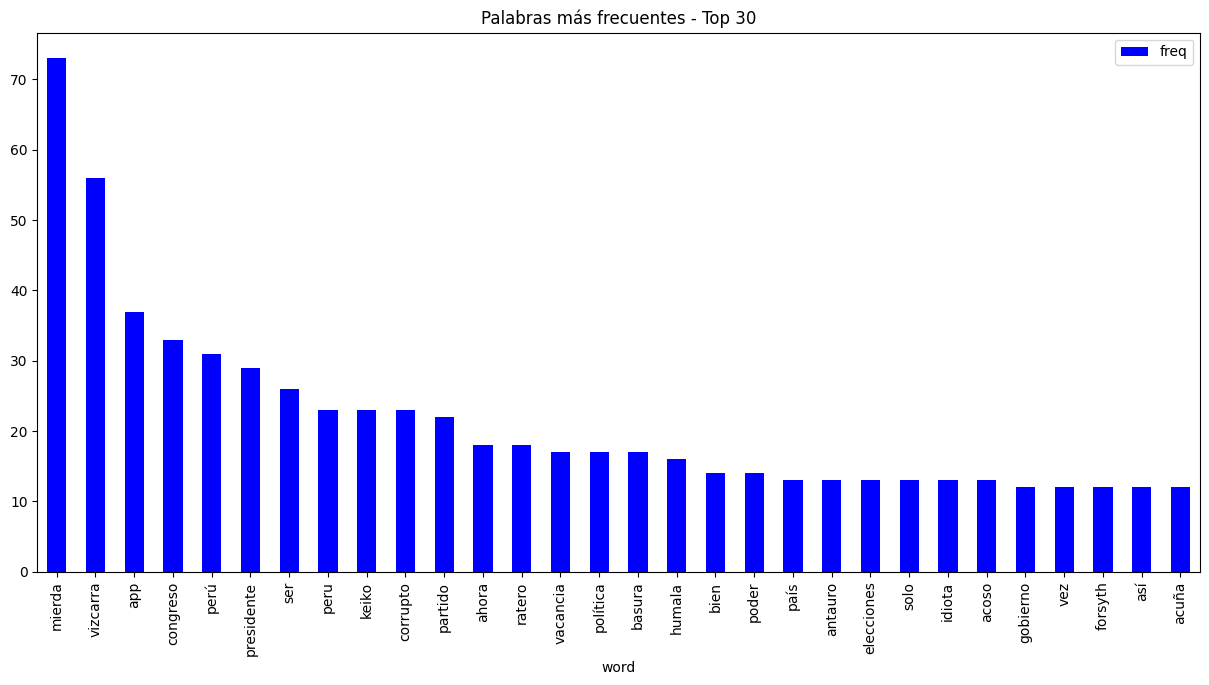

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

dataset_full= pd.concat([dataset_train, dataset_test])

words = cv.fit_transform(dataset_full.Tweet_Limpio)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')

plt.title("Palabras más frecuentes - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulario de revisiones')

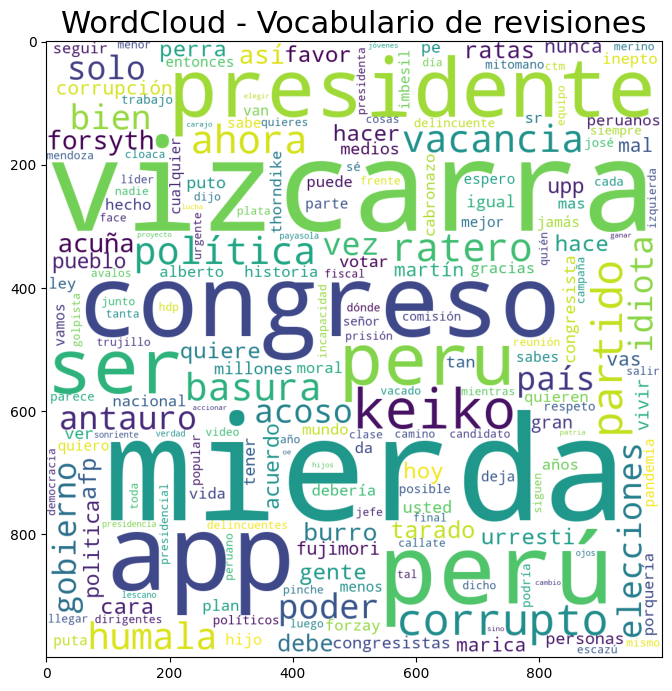

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulario de revisiones", fontsize = 22)

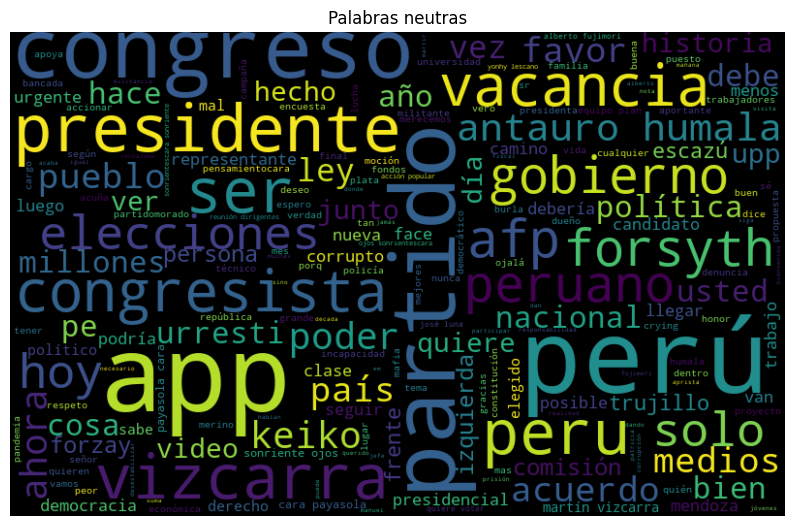

In [12]:
normal_words =' '.join([text for text in dataset_full['Tweet_Limpio'][dataset_full['Y'] == "noAcoso"].drop_duplicates()])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Palabras neutras')
plt.show()

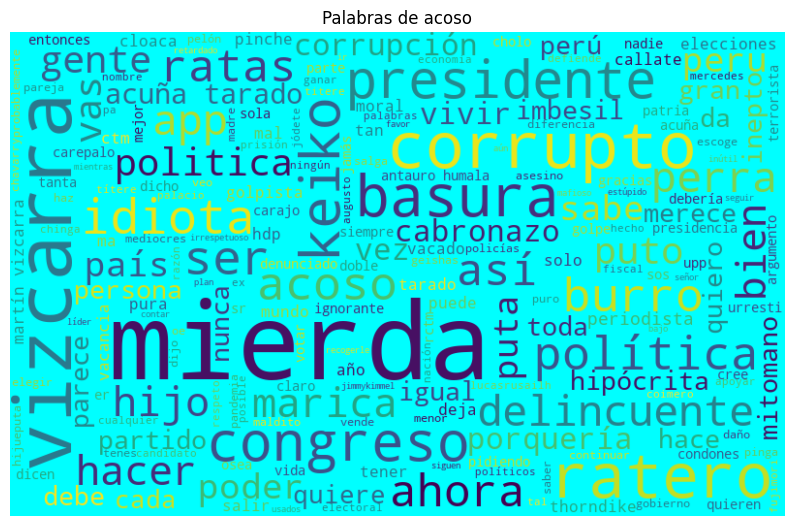

In [13]:
negative_words =' '.join([text for text in dataset_full['Tweet_Limpio'][dataset_full['Y'] == "acoso"].drop_duplicates()])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Palabras de acoso')
plt.show()

## TF - TF-idf

In [14]:
data_train = dataset_train['Tweet_Limpio'].values.tolist()
data_test = dataset_test['Tweet_Limpio'].values.tolist()

In [15]:
vectorizer = TfidfVectorizer(max_features=100, dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)

FV_train = vectorizer.fit_transform(data_train)
FV_train = FV_train.toarray()

FV_test = vectorizer.fit_transform(data_test)
FV_test = FV_test.toarray()

In [16]:
dataset_train['FV'] = FV_train.tolist()
dataset_train.head(10)

,Tweet,Y,Tweet_Limpio,FV
0,RT @CesarAcunaP: Es necesario monitorear los a...,noAcoso,necesario monitorear avances gobierno respecto...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4981928467750..."
2,RT @CarmenOmonte: Reunidos para trabajar por e...,noAcoso,reunidos trabajar país peruanos dirigentes app t,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4501298069953..."
3,RT @CesarAcunaP: En Trujillo estamos junto a l...,noAcoso,trujillo junto dirigencia fijar lineamientos d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,En Trujillo estamos junto a la dirigencia y la...,noAcoso,trujillo junto dirigencia fijar lineamientos d...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11,RT @JovenesMorados_: Frente al desempleo por l...,noAcoso,frente desempleo pandemia jóvenes mujeres enca...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,@julioguzmanperu ahi te hablan https://t.co/FQ...,noAcoso,ahi hablan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,@julioguzmanperu @partidomorado Hijos de la gr...,acoso,hijos gran p vende patria jodan rechazado cara...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,RT @Pulmon_de_Susan: @julioguzmanperu @partido...,noAcoso,susan oe pata pilar técnico acuerdo escazú,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,RT @partidomorado: El Partido Morado cuenta co...,noAcoso,partido morado cuenta técnicos decenas discipl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,"RT @JovenesMorados_: Mañana, a las 7pm, tenemo...",noAcoso,mañana pm viernesrepublicanos impacto cambio c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
dataset_test['FV'] = FV_test.tolist()
dataset_test.head(10)

,Tweet,Y,Tweet_Limpio,FV
1,"RT @CesarAcunaP: En la reunión, los dirigentes...",noAcoso,reunión dirigentes congresistas analizando pro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,@CesarAcunaP y ya decia yo de donde tanta plat...,noAcoso,decia tanta plata coca sanchez paredes x q inv...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,@CesarAcunaP @BancadaAPP @Peru_APP Qué ha echo...,noAcoso,app echo partido detener covid echo detener g,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3505182266235..."
6,@CesarAcunaP @BancadaAPP @Peru_APP Y que fue s...,noAcoso,app devolución afp millones aportantes ex apor...,"[0.0, 0.0, 0.0, 0.7515567541122437, 0.0, 0.0, ..."
7,@CesarAcunaP @BancadaAPP @Peru_APP Estimado Ce...,noAcoso,app estimado cesar podría triunfar partido hac...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6735908985137..."
8,"En la reunión, los dirigentes y congresistas e...",noAcoso,reunión dirigentes congresistas analizando pro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,Extiendo mi solidaridad con el fundador de @po...,noAcoso,extiendo solidaridad fundador peru josé luna g...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,RT @ZENAIDASOLISG: Por fin el Perú tendrá una ...,noAcoso,fin perú ley antimonopolio día histórico parti...,"[0.0, 0.0, 0.0, 0.0, 0.4903067648410797, 0.0, ..."
14,@julioguzmanperu @partidomorado https://t.co/s...,noAcoso,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,@julioguzmanperu @partidomorado Me cago en est...,acoso,cago jóvenes ignorantes carajo nunca hablaron ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
preprocessed_dataset, labels =  preprocess_dataset(dataset_train)

preprocessed_dataset_test, labels =  preprocess_dataset(dataset_test)

Para la columna 'Y', la codificación fue: {0: 'acoso', 1: 'noAcoso'}
Para la columna 'Y', la codificación fue: {0: 'acoso', 1: 'noAcoso'}


## Model Parameters


In [19]:
x_train = np.array(preprocessed_dataset.FV.to_list())
y_train = preprocessed_dataset.Y.values

x_test = np.array(preprocessed_dataset_test.FV.to_list())
y_test = preprocessed_dataset_test.Y.values

In [20]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((331, 100), (142, 100), (331,), (142,))

In [21]:
#Probamos con 7 modelos
clf1 = RandomForestClassifier(n_estimators =  100,  n_jobs=-1, random_state = 5)
clf2 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, random_state = 5)
clf3 = XGBClassifier(nthreads = -1, random_state = 5)
clf4 = AdaBoostClassifier(random_state = 5)
clf5 = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(1, ), random_state=5, max_iter=100)
clf6 = LGBMClassifier(n_estimators=100, random_state=5, max_depth=-1)
clf7 = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

classifiers = [
               ('RandomForest', clf1), ('GradientBoost', clf2), 
               ('XGBoost', clf3), ('AdaBoost', clf4),  
               ('RNN', clf5), ('LGBM', clf6), ('SVC', clf7)   
               ]

model_data = []
for clf_name, clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred_proba = clf.predict_proba(x_test)[::,1]
    
    confusion_matrix = metrics.confusion_matrix(y_train, clf.predict(x_train))
    TN = confusion_matrix[0,0]
    FN = confusion_matrix[1,0]
    FP = confusion_matrix[0,1]
    TP = confusion_matrix[1,1]
    exactitud = (TP + TN)/ (TP + TN + FP + FN)
    precision = TP/ (TP + FP)
    sensibilidad = TP/ (TP + FN)
    model_data.append([clf_name, 
                clf.score(x_train, y_train), 
                clf.score(x_test, y_test),
                roc_auc_score(y_test, y_pred_proba),
                exactitud, precision, sensibilidad])
    
df_model = pd.DataFrame(data=model_data, columns=['Modelo',	'train accuracy',	'test accuracy',	'AUC score',	'Exactitud',	'Precisión',	'Sensibilidad'])

df_model.sort_values(by=['AUC score'], ascending=False) 

,Modelo,train accuracy,test accuracy,AUC score,Exactitud,Precisión,Sensibilidad
4,RNN,0.879154,0.704225,0.717440,0.879154,0.819588,0.969512
0,RandomForest,0.909366,0.683099,0.709879,0.909366,0.856383,0.981707
3,AdaBoost,0.864048,0.654930,0.662500,0.864048,0.787440,0.993902
6,SVC,0.876133,0.612676,0.661190,0.876133,0.821990,0.957317
1,GradientBoost,0.897281,0.626761,0.649093,0.897281,0.831633,0.993902
2,XGBoost,0.818731,0.654930,0.637500,0.818731,0.745283,0.963415
5,LGBM,0.661631,0.584507,0.500504,0.661631,0.600000,0.951220


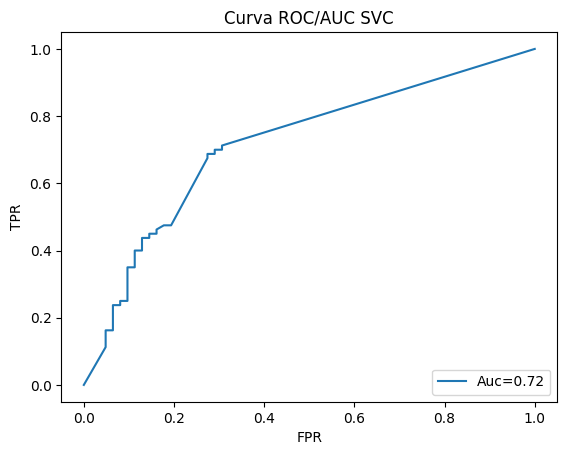

In [22]:
clf5.fit(x_train, y_train)
y_pred_proba = clf5.predict_proba(x_test)[::,1]

fpr, tpr, th = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.title("Curva ROC/AUC SVC")
plt.plot(fpr,tpr,label="Auc={:.2f}".format(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, classification_report

Y_pred = clf5.predict(x_test)
accuracy_score(y_test, Y_pred)

0.704225352112676

In [24]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        62
           1       0.76      0.69      0.72        80

    accuracy                           0.70       142
   macro avg       0.70      0.71      0.70       142
weighted avg       0.71      0.70      0.71       142



In [25]:
labels

{0: 'acoso', 1: 'noAcoso'}

In [26]:
texto = "presidente es una buena persona"
fv = vectorizer.transform([texto]).toarray()

labels[clf5.predict(fv)[0]]

'noAcoso'

In [27]:
texto = "congresista es un ratero"
fv = vectorizer.transform([texto]).toarray()

labels[clf5.predict(fv)[0]]

'acoso'